# Create the RLFED environment

In the context of this RLFED (Reinforcement learning for education) environment, we are approaching the the problem in the following way:
- This is a systems level problem that is being solved. That is, that the problem we are solving is about a systems level approach rather than an individual based optimiation problem
- The first step is a class classification task to classify what category of risk the student belongs to so that the correct intervention and data can be rendered based on the specific student needs. There are several experiments around this classification problem, but in the first instance we are assuming that the classification was a perfect world scenario - that is, that the classification was perfect for the given student.
- The MAB (multi armed bandit) arms each represents an intervention. In the experiment, we will have 4 arms, representing the following instances: Arm 1; the incorrect intervention, Arm 2; an intervention with an unknown consequence, Arm 3; the ideal intervention, Arm 4; an intervention that may work, but not for all instances.
- All the intervention distributions per class are labelled by experts, and that the interventions are perfect. This means that we will assume that if the correct arm is being pulled for a given student, that this means that the correct intervention was used given this problem based on an offline evaluation of the intervention.

In the first instance, we are setting up a basic environment:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Environment(object):

  def __init__(self, reward_probabilities, actual_rewards):
    if len(reward_probabilities) != len(actual_rewards):
      raise Exception(f"size of reward_probabilities : {len(reward_probabilities)} does not match size of actual rewards : {len(actual_rewards)}")

    self.reward_probabilities = reward_probabilities
    self.actual_rewards = actual_rewards
    self.k_arms = len(reward_probabilities)

  def choose_arm(self, arm):
    if arm < 0 or arm >= self.k_arms:
      raise Exception(f"arm must be between 0 and {self.k_arms -1}")

    return self.actual_rewards[arm] if np.random.random() < self.reward_probabilities[arm] else 0.0

In [3]:
env = Environment(reward_probabilities=[0.62, 0.05, 0.87, 0.49], actual_rewards=[1.0, 1.0, 1.0, 1.0])

In [4]:
[env.choose_arm(0) for _ in range(10)]

[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0]

In [5]:
[env.choose_arm(1) for _ in range(10)]

[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]

In [6]:
[env.choose_arm(2) for _ in range(10)]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0]

In [7]:
[env.choose_arm(3) for _ in range(10)]

[1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0]

# Adding context

So in the above mentioned code, the environment is base skeleton and as simple as it can be. In fact, in the example above the class classifications are not even factored in. So to do this, let us assume the following example given 4 numbers:
- 1) the student will pass, no matter the intervention
- 2) the student will fail, but will pass if the correct intervention is given and stand a 70% chance of passing if the intervention that may work is recommended, and 50% if an intervention with an unknown consequence is given
- 3) the student will fail, but will only pass if the correct intervention is given, and stand a 50% chance of passing if the intervention that may work is recommended
- 4) the student will fail, but will only pass 50% of the time if the correct intervention is given

Keep in mind:
- Arm 1; the incorrect intervention
- Arm 2; an intervention with an unknown consequence
- Arm 3; the ideal intervention
- Arm 4; an intervention that may work, but not for all instances.

So to imliment this, for simplicity sake, we will create an environment for each of the aforementioned classes of students. We will also assume that there is an expert panel that decides the interventions for each of the classes above. We are not concerned over which intervention fits with which problem, and will assume that the right arm for the right intervention, follows the conditions above. Let us start with the first environment, category 1:

In [8]:
env1 = Environment(reward_probabilities=[0.62, 0.05, 0.87, 0.49], actual_rewards=[1.0, 1.0, 1.0, 1.0])

Next, let us build an environment for the following condition:
- 2) the student will fail if the incorrect intervention is given, but will pass if the correct intervention is given and stand a 70% chance of passing if the intervention that may work is recommended, and 50% if an intervention with an unknown consequence is given

Keep in mind
- Arm 1; the incorrect intervention
- Arm 2; an intervention with an unknown consequence
- Arm 3; the ideal intervention
- Arm 4; an intervention that may work, but not for all instances.

In [9]:
env2 = Environment(reward_probabilities=[0.62, 0.05, 0.87, 0.49], actual_rewards=[0.0, 0.5, 1.0, 0.7])

Next, let us build an environment for the following condition:
- 3) the student will fail if the incorrect intervention is given and if the intervention of an unknow significance is reccomended, but will only pass if the correct intervention is given, and stand a 50% chance of passing if the intervention that may work is recommended

Keep in mind
- Arm 1; the incorrect intervention
- Arm 2; an intervention with an unknown consequence
- Arm 3; the ideal intervention
- Arm 4; an intervention that may work, but not for all instances.

In [10]:
env3 = Environment(reward_probabilities=[0.62, 0.05, 0.87, 0.49], actual_rewards=[0.0, 0.0, 1.0, 0.5])

Next, let us build an environment for the following condition:
- 4) the student will fail, but will only pass 50% of the time if the correct intervention is given

Keep in mind
- Arm 1; the incorrect intervention
- Arm 2; an intervention with an unknown consequence
- Arm 3; the ideal intervention
- Arm 4; an intervention that may work, but not for all instances.

In [11]:
env4 = Environment(reward_probabilities=[0.62, 0.05, 0.87, 0.49], actual_rewards=[0.0, 0.0, 0.5, 0.0])

# Incremental Sampling For Non-Stationary Bandit Problems
## new_estimage = old_estimate + (1/n) * (reward - old_estimate)

Calculationg Average Through Incremental Sampling
The obvious way to calculate the average of a finite set of numbers it to sum the list of numbers and divide by the length of the list. However, it is not always feasible to store all numbers into a list before calculating their average. The incremental sampling technique is a memory-efficient way of estimating the average of a larger collection of numbers on the fly.   

In the incremental sampling formular above, the term (1/n) gets smaller as n gets larger. This means that, rewards from later time steps contribute little to the new estimate of the average and this makes it unfit for bandit problems with non-stationary reward distributions. To curb this, another form of this formula with a fixed step size should be used. The step size must be a number between 0 and 1. This way, rewards from later time steps contribute more to the estimation of the average and this makes it fit for non-stationary bandit problems. The following general update rule is very common throughout Reinforcement Learning especially in Temporal Difference learning algorithms.

## new_estimage = old_estimate + (step_size) * (reward - old_estimate)

Let's verify this in code.

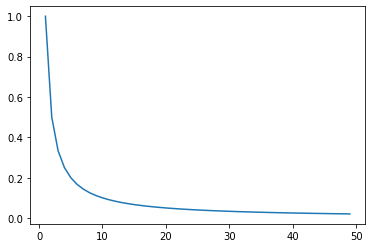

In [12]:
time_steps = np.arange(1,50)
weights = 1/time_steps
plt.plot(time_steps, weights)

As seen above, the highest weight is given at time 1, but as time = 1 + n occurs, the weight decreases

# Creating the agent

So in the sections below, I will play with different RL agent algorithms, starting with the baseline, an agent that just randomly "pulls" an arm, or in this context, chooses an intervention based on the classification

In [13]:
class RandomAgent(object):

  def __init__(self, env, max_iterations=500):
    self.env = env
    self.iterations = max_iterations

    self.q_values = np.zeros(self.env.k_arms)
    self.arm_counts = np.zeros(self.env.k_arms)
    self.arm_rewards = np.zeros(self.env.k_arms)

    self.rewards = [0.0]
    self.cum_rewards = [0.0]

  def act(self):
    for i in range(self.iterations):
      arm = np.random.choice(self.env.k_arms)
      reward = self.env.choose_arm(arm)

      self.arm_counts[arm] = self.arm_counts[arm] + 1
      self.arm_rewards[arm] = self.arm_rewards[arm] + reward

      self.q_values[arm] = self.q_values[arm] + (1/self.arm_counts[arm]) * (reward - self.q_values[arm])
      self.rewards.append(reward)
      self.cum_rewards.append(sum(self.rewards) / len(self.rewards))

    return {"arm_counts": self.arm_counts, "rewards": self.rewards, "cum_rewards": self.cum_rewards}

In [14]:
test_env1 = env1
random_agent1 = RandomAgent(test_env1)
random_agent_result1 = random_agent1.act()

In [15]:
test_env2 = env2
random_agent2 = RandomAgent(test_env2)
random_agent_result2 = random_agent2.act()

In [16]:
test_env3 = env3
random_agent3 = RandomAgent(test_env3)
random_agent_result3 = random_agent3.act()

In [17]:
test_env4 = env4
random_agent4 = RandomAgent(test_env4)
random_agent_result4 = random_agent4.act()

In [18]:
total_rewards = sum(random_agent_result1["rewards"])
print(f"Total Reward : {total_rewards}")

Total Reward : 259.0


In [19]:
print(f"Environment Reward Probabilities : {test_env1.reward_probabilities}")
print(f"Random Agent Action Values : {random_agent1.q_values}")

Environment Reward Probabilities : [0.62, 0.05, 0.87, 0.49]
Random Agent Action Values : [0.60483871 0.01886792 0.88135593 0.51315789]


<BarContainer object of 4 artists>

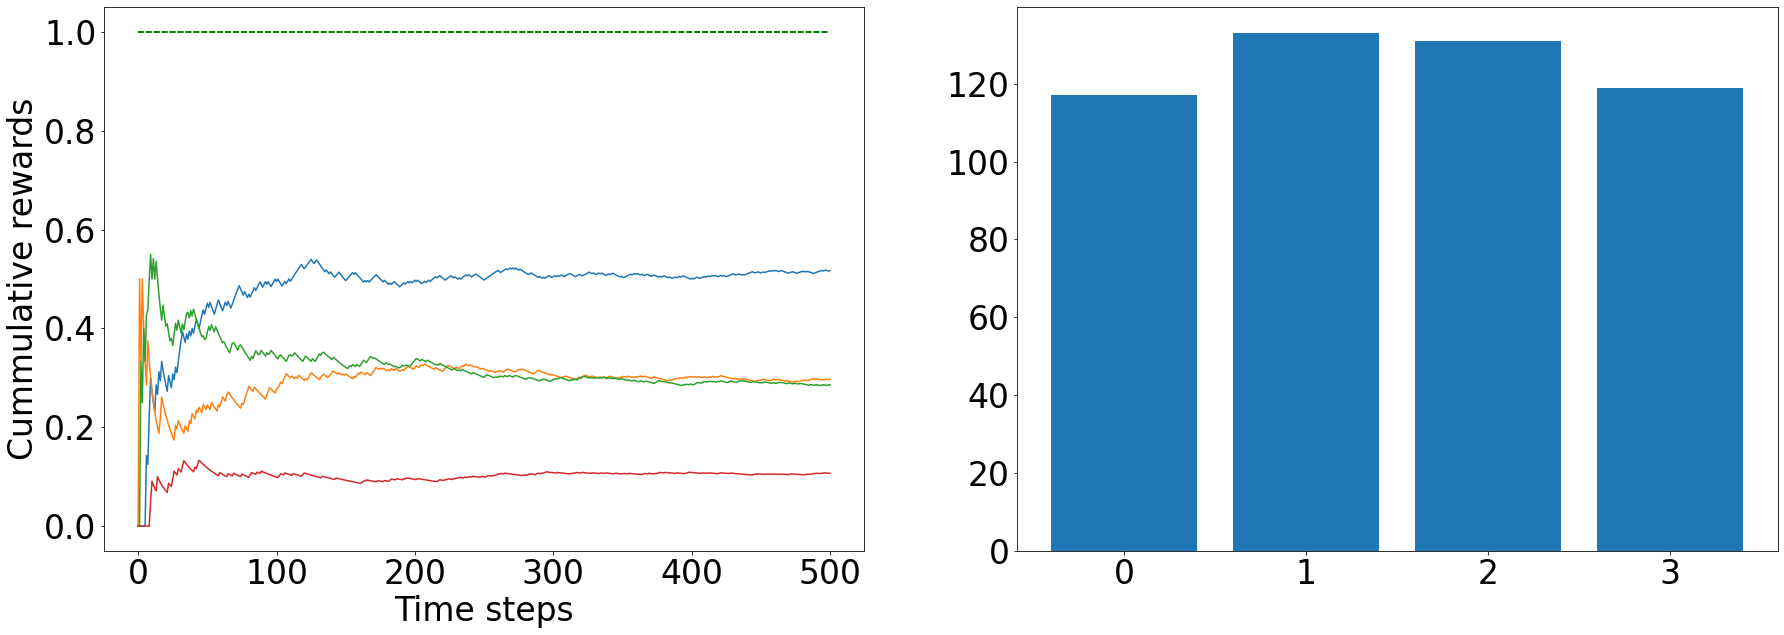

In [32]:
cum_rewards1 = random_agent_result1["cum_rewards"]
arm_counts1 = random_agent_result1["arm_counts"]

cum_rewards2 = random_agent_result2["cum_rewards"]
arm_counts2 = random_agent_result2["arm_counts"]

cum_rewards3 = random_agent_result3["cum_rewards"]
arm_counts3 = random_agent_result3["arm_counts"]

cum_rewards4 = random_agent_result4["cum_rewards"]
arm_counts4 = random_agent_result4["arm_counts"]

fig = plt.figure(figsize=[30,10])

ax1 = fig.add_subplot(121)
ax1.plot([1.0 for _ in range(random_agent1.iterations)], "g--", label="target cummulative reward")
ax1.plot([1.0 for _ in range(random_agent2.iterations)], "g--", label="target cummulative reward")
ax1.plot([1.0 for _ in range(random_agent3.iterations)], "g--", label="target cummulative reward")
ax1.plot([1.0 for _ in range(random_agent4.iterations)], "g--", label="target cummulative reward")
ax1.plot(cum_rewards1, label="cummulative rewards")
ax1.plot(cum_rewards2, label="cummulative rewards")
ax1.plot(cum_rewards3, label="cummulative rewards")
ax1.plot(cum_rewards4, label="cummulative rewards")
ax1.set_xlabel("Time steps")
ax1.set_ylabel("Cummulative rewards")

ax2 = fig.add_subplot(122)
ax2.bar([i for i in range(len(arm_counts3))], arm_counts3)

Text(0, 0.5, 'Cumulative reward')

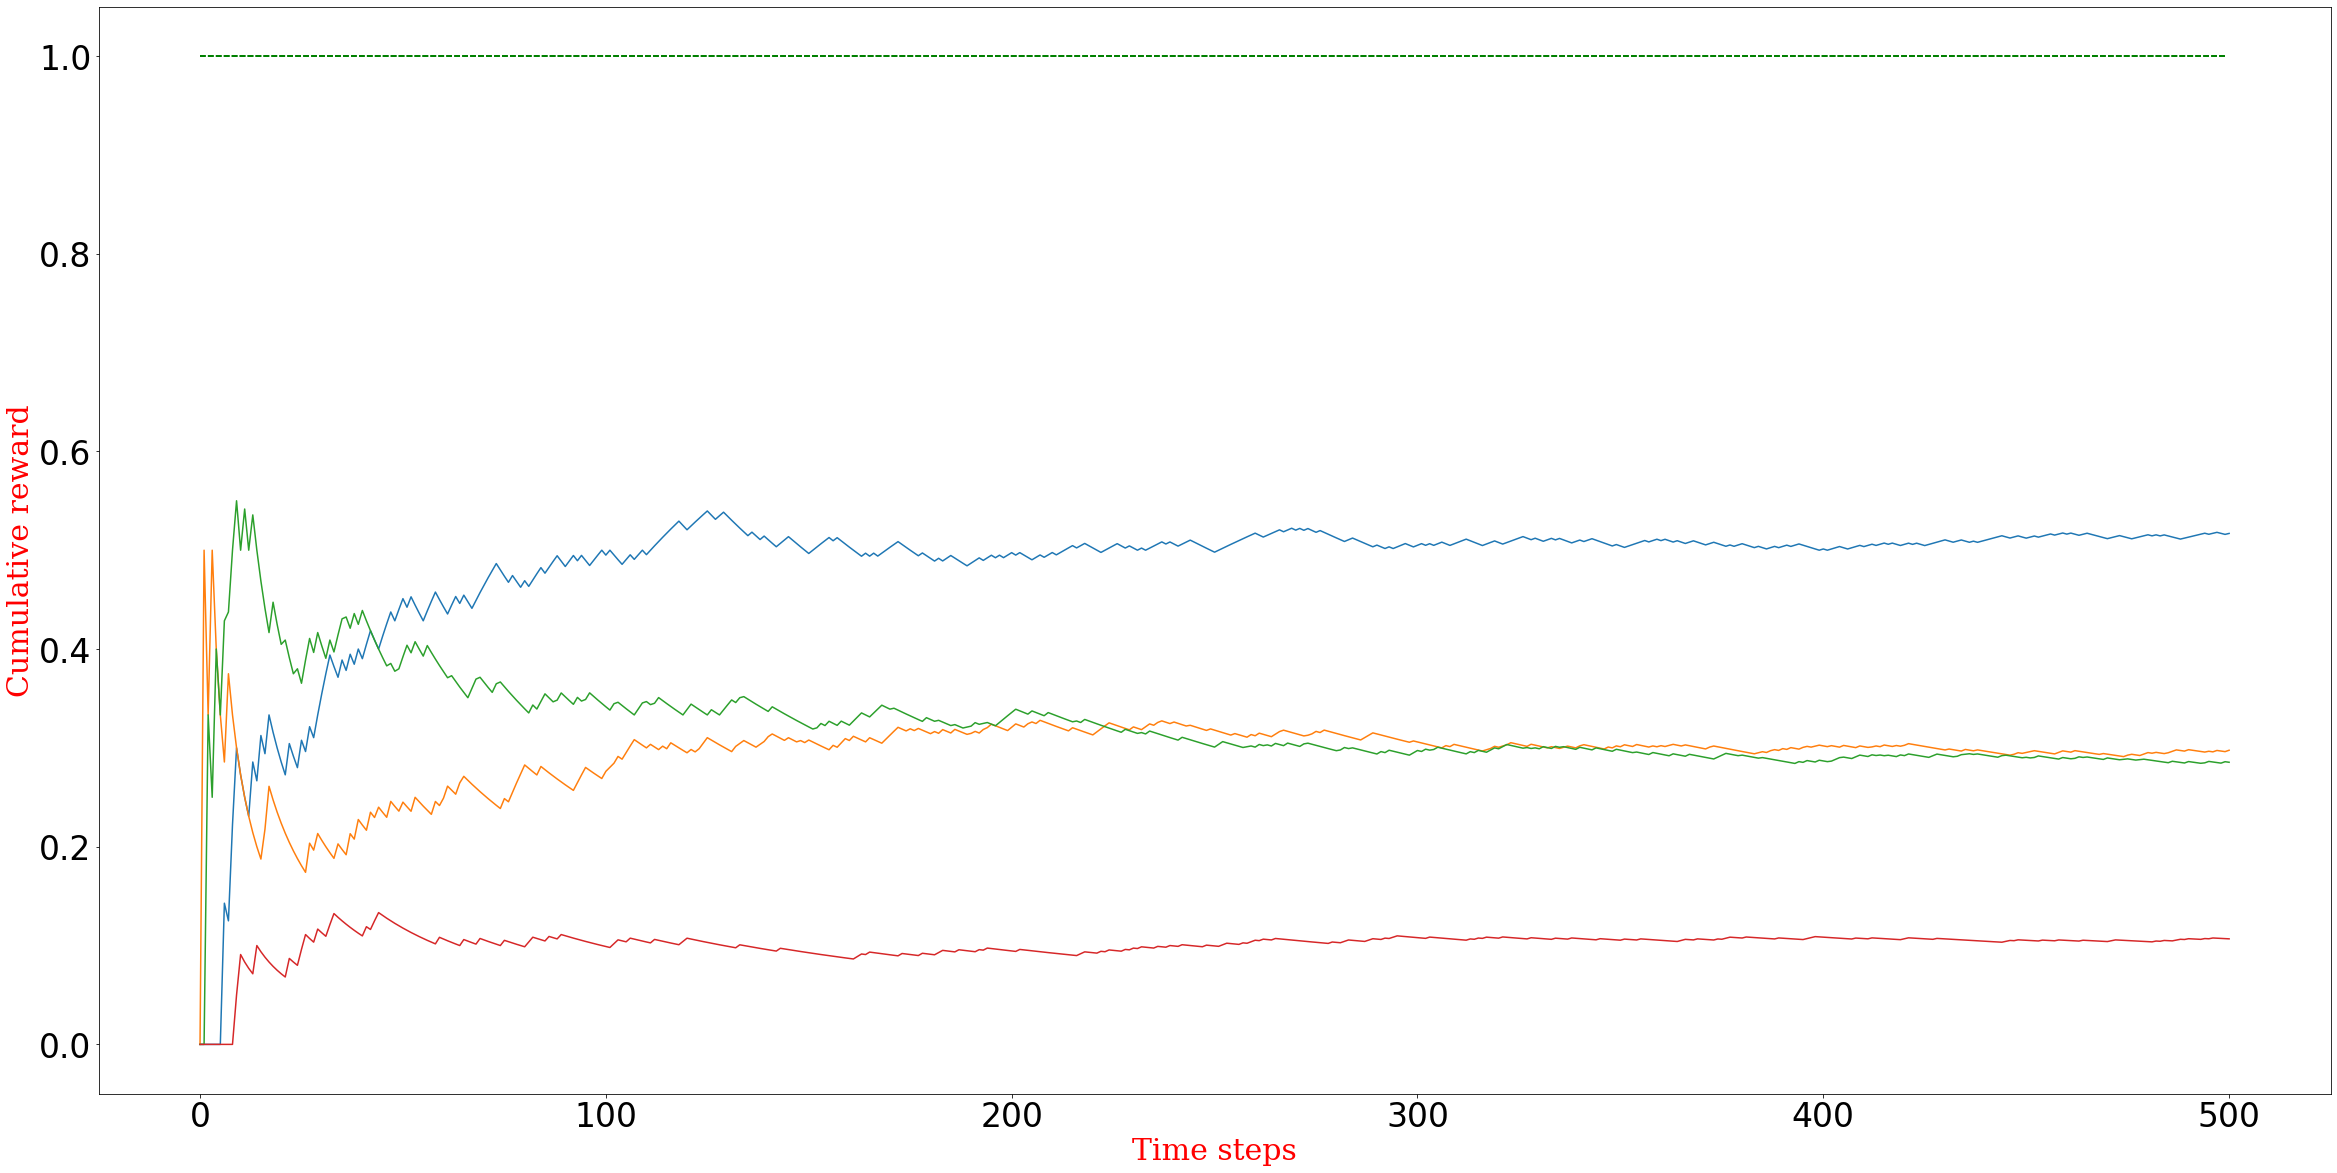

In [35]:

ax2 = plt.figure(figsize=[40,20])
plt.plot([1.0 for _ in range(random_agent1.iterations)], "g--", label="target cummulative reward")
plt.plot([1.0 for _ in range(random_agent2.iterations)], "g--", label="target cummulative reward")
plt.plot([1.0 for _ in range(random_agent3.iterations)], "g--", label="target cummulative reward")
plt.plot([1.0 for _ in range(random_agent4.iterations)], "g--", label="target cummulative reward")

plt.rcParams['font.size'] = '33'

plt.plot(cum_rewards1, label="cummulative rewards")
plt.plot(cum_rewards2, label="cummulative rewards")
plt.plot(cum_rewards3, label="cummulative rewards")
plt.plot(cum_rewards4, label="cummulative rewards")

plt.xlabel("Time steps", {'family':'serif','color':'red','size':30})
plt.ylabel("Cumulative reward", {'family':'serif','color':'red','size':30})

<BarContainer object of 4 artists>

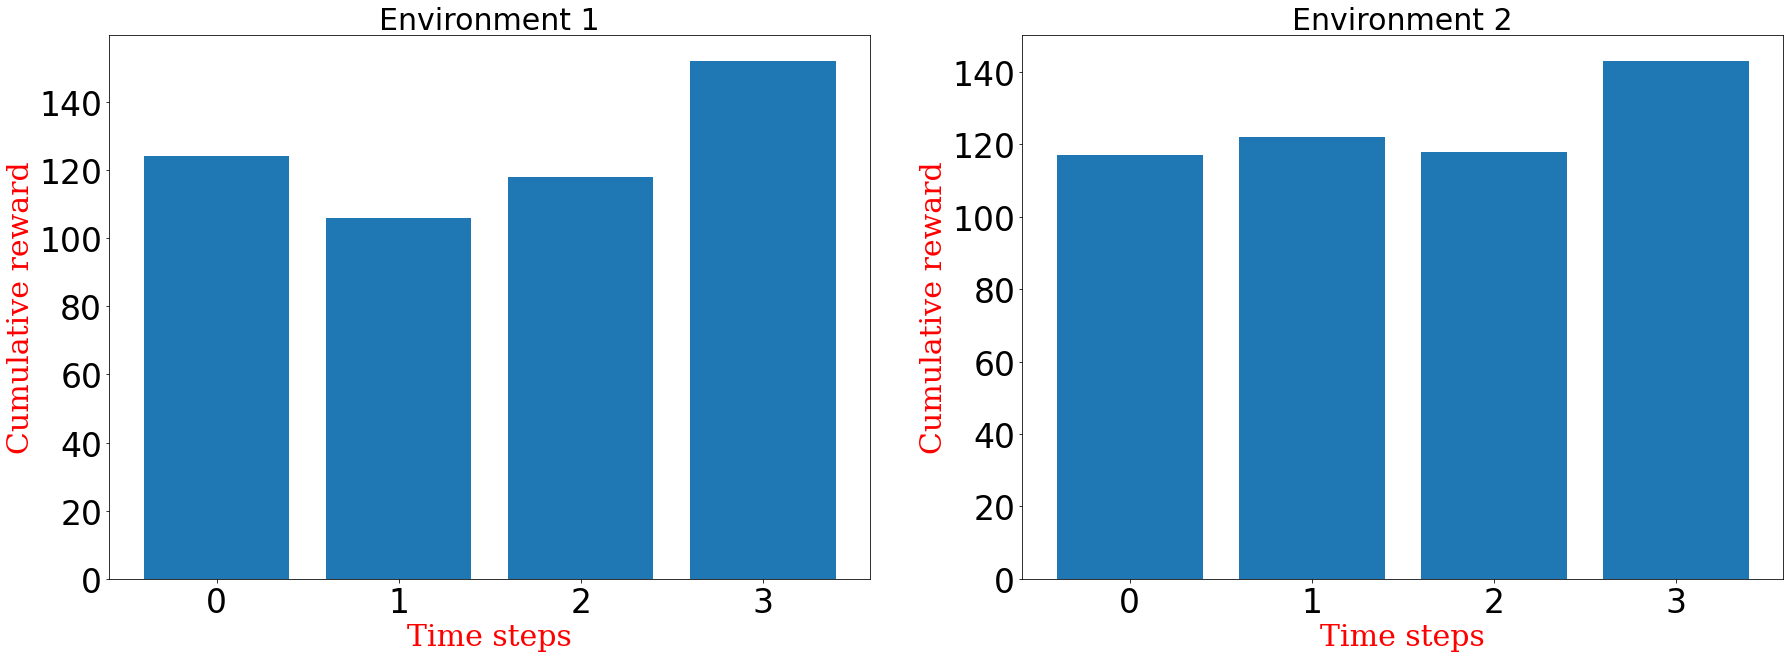

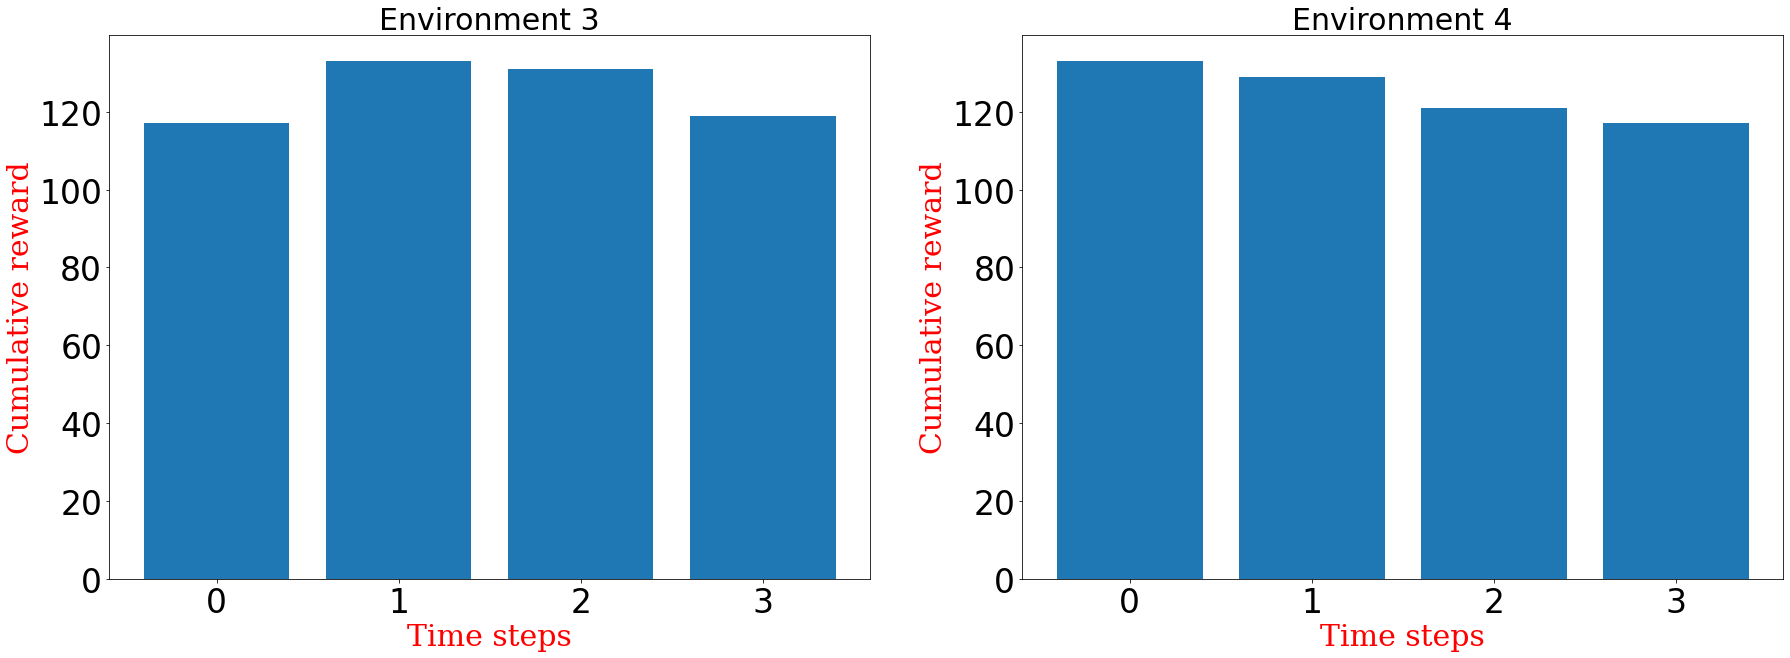

In [31]:
fig = plt.figure(figsize=[30,10])

ax1 = fig.add_subplot(121)
plt.xlabel("Time steps", {'family':'serif','color':'red','size':30})
plt.ylabel("Cumulative reward", {'family':'serif','color':'red','size':30})
ax1.set_title('Environment 1', fontsize=30)

ax2 = fig.add_subplot(122)
plt.xlabel("Time steps", {'family':'serif','color':'red','size':30})
plt.ylabel("Cumulative reward", {'family':'serif','color':'red','size':30})
ax2.set_title('Environment 2', fontsize=30)

ax1.bar([i for i in range(len(arm_counts1))], arm_counts1)
ax2.bar([i for i in range(len(arm_counts2))], arm_counts2)

fig = plt.figure(figsize=[30,10])
ax3 = fig.add_subplot(121)
plt.xlabel("Time steps", {'family':'serif','color':'red','size':30})
plt.ylabel("Cumulative reward", {'family':'serif','color':'red','size':30})
ax3.set_title('Environment 3', fontsize=30)

ax4 = fig.add_subplot(122)
plt.xlabel("Time steps", {'family':'serif','color':'red','size':30})
plt.ylabel("Cumulative reward", {'family':'serif','color':'red','size':30})
ax4.set_title('Environment 4', fontsize=30)

ax3.bar([i for i in range(len(arm_counts3))], arm_counts3)
ax4.bar([i for i in range(len(arm_counts4))], arm_counts4)